In [ ]:
## 1. Transform data to record format
## First dataset from http://www.robots.ox.ac.uk/~vgg/data/scenetext/
## This method failed, because 

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import math
import numpy as np
import scipy.io as sio
import gzip
from zipfile import ZipFile
import matplotlib.pyplot as plt
import cv2
import sys
sys.path.insert(0,'../')
sys.path.insert(0,'../processing/')
from datasets import sythtextprovider
import tensorflow as tf
import skimage.io as skio
#tf.InteractiveSession()
from PIL import Image
import re
import os
slim = tf.contrib.slim
tf.__version__
#from image_processing2 import *
from processing import txt_preprocessing
import tf_extended as tfe
from processing import tf_image
from nets import txtbox_300
import tf_utils
from nets import custom_layers
import load_batch

In [2]:
def visualize_bbox(image, bboxes):
    """
    Input: image (height, width, channels)
           bboxes (numof bboxes, 4) in order(ymin, xmin, ymax, xmax)
                  range(0,1) 
    """
    numofbox = bboxes.shape[0]
    width = image.shape[1]
    height = image.shape[0]
    def norm(x):
        if x < 0:
            x = 0
        else:
            if x > 1:
                x = 1
        return x
    xmin = [int(i * width) for i in bboxes[:,1]]
    ymin = [int(i * height) for i in bboxes[:,0]]
    ymax = [int(i * height) for i in bboxes[:,2]]
    xmax = [int(i * width) for i in bboxes[:,3]]

    for i in range(numofbox):
        image = cv2.rectangle(image,(xmin[i],ymin[i]),
                             (xmax[i],ymax[i]),(0,255,255))
    print [ymin,xmin,ymax,xmax]
    skio.imshow(image)
    skio.show()

text_shape (300, 300)
file_path: ../data/sythtext/*.tfrecord
122.283 -72.6077
(300, 300, 3)
147.288 -124.67
[[226, 280, 77], [-15, -17, -31], [274, 302, 174], [98, 88, 84]]


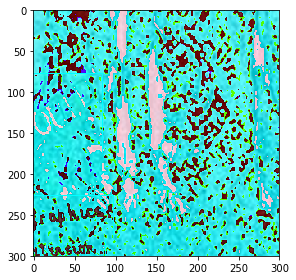

[[72, 261, 255, 278, 275, 291, 289, 289, 198, 14, 30], [282, 0, 53, 10, 52, 24, 71, 112, 45, 242, 252], [106, 277, 273, 287, 284, 297, 296, 297, 235, 25, 42], [300, 53, 116, 53, 110, 71, 108, 171, 108, 283, 277]]


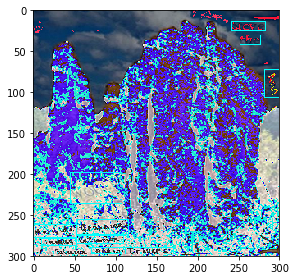

In [144]:
#out_shape = [700,700]
with tf.Graph().as_default(): 
    # build a net
    text_net = txtbox_300.TextboxNet()
    text_shape = text_net.params.img_shape
    print 'text_shape '+  str(text_shape)
    text_anchors = text_net.anchors(text_shape)
    
    ## dataset provider
    dataset = sythtextprovider.get_datasets('../data/sythtext/',file_pattern='*.tfrecord')
    
    data_provider = slim.dataset_data_provider.DatasetDataProvider(
            dataset, common_queue_capacity=32, common_queue_min=2)
    
    [image, shape, glabels, gbboxes,height,width] = \
    data_provider.get(['image', 'shape',
                     'object/label',
                     'object/bbox','height','width'])

    
    image_train, tlabels, tbboxes,num = \
        txt_preprocessing.preprocess_image(image,  glabels,gbboxes, 
                                        [300,300],is_training=True)
    image_test, elabels, ebboxes, bbox_img,num = \
        txt_preprocessing.preprocess_image(image,  glabels,gbboxes, 
                                        [300,300],is_training=False)
    batch_image = slim.batch_norm(image_train)
    #scala_image = tf.cast(image_train, tf.uint8)
    
    
    with tf.Session() as sess: 
        sess.run(tf.global_variables_initializer())
        with slim.queues.QueueRunners(sess):
            for i in xrange(1):
                image_, batch_image_,image_test_,bbox_,test_box= sess.run([image_train,batch_image,image_test,tbboxes,ebboxes])
                #image_ = image_*255
                print image_.max(),image_.min()
                print image_.shape
                print image_test_.max(), image_test_.min()
                #image_ = image_ * 255.
                image_ = image_.astype(np.uint8)
                visualize_bbox(image_, bbox_)
                image_test_ = image_test_.astype(np.uint8)
                visualize_bbox(image_test_, test_box)
                
                

[[72, 261, 255, 278, 275, 291, 289, 289, 198, 14, 30], [282, 0, 53, 10, 52, 24, 71, 112, 45, 242, 252], [106, 277, 273, 287, 284, 297, 296, 297, 235, 25, 42], [300, 53, 116, 53, 110, 71, 108, 171, 108, 283, 277]]


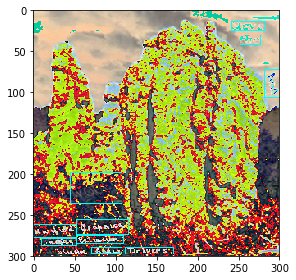

In [128]:
image_test_ = image_test_ * 255.0
image_test_ = image_test_.astype(np.uint8)
visualize_bbox(image_test_, test_box)


In [ ]:
image_ = image_ *255.0
image_ = image_.astype(np.uint8)
visualize_bbox(image_, bbox_)

In [ ]:
image_ = image_.astype(np.uint8)
#skio.imshow(np.uint8(image_bbox_p[0,:,:,:])*255)
skio.imshow(image_)

In [ ]:
for i in range(6):
    pmask = gscores_[i] > 0.5
    print np.sum(pmask)
bbox_

In [ ]:
for i in range(6):
    print np.where(gscores_[i] >0.1)
gscores_[0].shape

In [ ]:
loss

In [ ]:
pos_loss = 0
neg_loss = 0
for i in range(6):
    p_mask = np.int32(np.greater(b_gscores_[i] , 0.5))
    print np.sum(p_mask)
    n_mask = np.int32(np.less(b_gscores_[i] , 0.5))
    pos_loss += np.mean(pow((p_mask * (logits_[i][:,:,:,:,:,1] - p_mask)),2))
    neg_loss += np.mean(pow((n_mask * (logits_[i][:,:,:,:,:,0] - n_mask)),2))
print pos_loss,neg_loss